In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import seaborn as sn
from scipy.stats import gaussian_kde
from scipy.spatial.distance import euclidean
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from matplotlib import rc
from matplotlib import font_manager
from scipy.signal import savgol_filter
import os 
import hedfpy
import pandas as pd
import yaml

from hedfpy.EDFOperator import EDFOperator
from hedfpy.HDFEyeOperator import HDFEyeOperator
from hedfpy.EyeSignalOperator import EyeSignalOperator, detect_saccade_from_data

sn.set(style="ticks")
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from pathlib import Path

from hedfpy.EyeSignalOperator import detect_saccade_from_data

In [2]:
cwd = Path(os.getcwd())
font_dirs = [cwd.parent.parent / "arial"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

rc("pdf", fonttype=42, use14corefonts=False)
rc("axes", linewidth=0.5)
rc("font", **{"family": "Arial"})
rc("text", usetex=False)
rc("xtick", labelsize=6)
rc("ytick", labelsize=6)
rc("axes", labelsize=7)
rc("legend", fontsize=6)

plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["ytick.minor.size"] = 1

# set up figure parameters
markeredgecolor = ".4"
bar_linewidth = 0.5
bar_alpha = 0.7
xticks_rotation = 45
marker = "s"
marker_edge_width = 0.5
markersize = 4 / 2.54
errorbar_linewidth = 0.5
errorbar_capsize = 0.7 / 2.54
errorbar_capthick = 0.5

In [3]:
settings_yaml_path = cwd.parent.parent / "settings.yml"
with open(settings_yaml_path, "r") as file:
    settings = yaml.safe_load(file)
bad_runs = settings["QC"]["bad_eye_tracking_runs"]
data_dir = Path(os.path.join(settings["general"]["data_dir"], "data"))

In [4]:
figure_result_dir = cwd.parent / "figures"

In [5]:
def con_eye_data(subject, run, alias="prf"):
    edf_file = str(
        data_dir
        / f"sourcedata/{subject}/ses-1/logs/{subject}_ses-1_run-{run}_Logs/{subject}_ses-1_run-{run}.edf"
    )
    dir_path = os.path.dirname(edf_file)
    # get file name without extension
    file_name = os.path.basename(edf_file)
    file_name = os.path.splitext(file_name)[0] + '.h5'
    file_path = os.path.join(dir_path, file_name)
    # print(file_path)

    low_pass_pupil_f, high_pass_pupil_f = 6.0, 0.01
    
    file_folder = os.path.dirname(edf_file)
    # initialize the hdfeyeoperator
    ho = HDFEyeOperator(os.path.splitext(edf_file)[0] + '.h5')
    # insert the edf file contents only when the h5 is not present.
    if not os.path.isfile(os.path.splitext(edf_file)[0] + '.h5'):
        ho.add_edf_file(edf_file)
        ho.edf_message_data_to_hdf(alias = alias)
        ho.edf_gaze_data_to_hdf(alias = alias, pupil_hp = high_pass_pupil_f, pupil_lp = low_pass_pupil_f)
    return ho

In [6]:
## run this block once to generate the h5 files from edf files
alias = "prf"
for subject in [
    "sub-001",
    "sub-002",
    "sub-004",
    "sub-005",
    "sub-007",
    "sub-009",
    "sub-012",
]:
    for run in ["1", "2", "3", "4", "5", "6"]:
        print(f"Processing {subject} run {run}...")
        ho = con_eye_data(subject, run)
        time_period = [
            ho.trial_properties(alias)["trial_start_EL_timestamp"].iloc[0],
            ho.trial_properties(alias)["trial_start_EL_timestamp"].iloc[-1],
        ]
        tracked_eye = ho.block_properties(alias)["eye_recorded"][0]
        gaze_data = [
            ho.signal_during_period(
                time_period=time_period,
                alias=alias,
                signal="gaze_x_int",
                requested_eye=tracked_eye,
            ),
            1024
            - ho.signal_during_period(
                time_period=time_period,
                alias=alias,
                signal="gaze_y_int",
                requested_eye=tracked_eye,
            ),
        ]

Processing sub-001 run 1...
Processing sub-001 run 2...
Processing sub-001 run 3...
Processing sub-001 run 4...
Processing sub-001 run 5...
Processing sub-001 run 6...
Processing sub-002 run 1...
Processing sub-002 run 2...
Processing sub-002 run 3...
Processing sub-002 run 4...
Processing sub-002 run 5...
Processing sub-002 run 6...
Processing sub-004 run 1...
Processing sub-004 run 2...
Processing sub-004 run 3...
Processing sub-004 run 4...
Processing sub-004 run 5...
Processing sub-004 run 6...
Processing sub-005 run 1...
Processing sub-005 run 2...
Processing sub-005 run 3...
Processing sub-005 run 4...
Processing sub-005 run 5...
Processing sub-005 run 6...
Processing sub-007 run 1...
Processing sub-007 run 2...
Processing sub-007 run 3...
Processing sub-007 run 4...
Processing sub-007 run 5...
Processing sub-007 run 6...
Processing sub-009 run 1...
Processing sub-009 run 2...
Processing sub-009 run 3...
Processing sub-009 run 4...
Processing sub-009 run 5...
Processing sub-009 r

In [7]:
def gaze_over_time(x, y):
    xy_data = np.array([np.array(x).squeeze(), np.array(y).squeeze()]).T
    vel = np.diff(xy_data, axis=0)
    vel_norm = np.linalg.norm(vel, axis=1)

    saccades = detect_saccade_from_data(
        xy_data=xy_data, l=6, minimum_saccade_duration=0.0025
    )

    main_sequence = np.array(
        [
            [
                sacc["peak_velocity"],
                sacc["expanded_amplitude"],
                sacc["expanded_duration"],
            ]
            for sacc in saccades
        ]
    )

    f = plt.figure(figsize=(14, 5))
    s = f.add_subplot(121)
    plt.plot(np.array(x) - 640)
    plt.plot(np.array(y) - 480)
    s.set_ylim([-640, 640])
    sn.despine(ax=s, offset=10)
    s.set_title("gaze x and y over time")
    for sacc in saccades:
        s.axvline(sacc["expanded_start_time"], lw=0.5, color="k")
        s.axvline(sacc["expanded_end_time"], lw=0.5, color="r")
    s.set_xlabel("time")
    s.set_ylabel("pixels on screen")

    s = f.add_subplot(222)
    plt.scatter(main_sequence[:, 0], main_sequence[:, 1], c="r")
    sn.despine(ax=s, offset=10)
    s.set_title("main sequence")
    s.set_xlabel("peak velocity")
    s.set_ylabel("amplitude")

    s = f.add_subplot(224)
    for sacc in saccades:
        plt.plot(
            vel_norm[sacc["expanded_start_time"] : sacc["expanded_end_time"]],
            "k",
            lw=1,
            alpha=0.5,
        )
    sn.despine(ax=s, offset=10)
    s.set_title("velocity profiles")
    plt.tight_layout()
    s.set_xlabel("velocity")
    s.set_ylabel("time [ms]")

In [8]:
def cal_pix_per_deg(screen_height_px, screen_height_cm, screen_distance_cm):
    """
    Calculate pixels per degree of visual angle.

    Parameters:
    screen_height_px (int): Width of the screen in pixels.
    screen_height_cm (float): Width of the screen in centimeters.
    screen_distance_cm (float): Distance from the eyes to the screen in centimeters.

    Returns:
    float: Pixels per degree of visual angle.
    """
    screen_height_deg = np.arctan((screen_height_cm / 2) / screen_distance_cm) * (
        180 / np.pi
    )
    print(f"Screen height in degrees: {screen_height_deg:.2f}°")
    pix_per_deg = screen_height_px / screen_height_deg
    return pix_per_deg


pix_per_deg = cal_pix_per_deg(
    screen_height_px=1080, screen_height_cm=39.29, screen_distance_cm=196
)
print(f"Pixels per degree: {pix_per_deg:.2f} px/deg")

Screen height in degrees: 5.72°
Pixels per degree: 188.69 px/deg


In [9]:
def con_eye_data(subject, run, alias="prf"):
    edf_file = str(
        data_dir
        / f"sourcedata/{subject}/ses-1/logs/{subject}_ses-1_run-{run}_Logs/{subject}_ses-1_run-{run}.edf"
    )
    dir_path = os.path.dirname(edf_file)
    # get file name without extension
    file_name = os.path.basename(edf_file)
    file_name = os.path.splitext(file_name)[0] + ".h5"
    file_path = os.path.join(dir_path, file_name)
    # print(file_path)

    low_pass_pupil_f, high_pass_pupil_f = 6.0, 0.01

    file_folder = os.path.dirname(edf_file)
    # initialize the hdfeyeoperator
    ho = HDFEyeOperator(os.path.splitext(edf_file)[0] + ".h5")
    # insert the edf file contents only when the h5 is not present.
    if not os.path.isfile(os.path.splitext(edf_file)[0] + ".h5"):
        ho.add_edf_file(edf_file)
        ho.edf_message_data_to_hdf(alias=alias)
        ho.edf_gaze_data_to_hdf(
            alias=alias, pupil_hp=high_pass_pupil_f, pupil_lp=low_pass_pupil_f
        )
    return ho

In [10]:
alias = "prf"

In [11]:
def remove_saccades_around_blinks(saccades, blink_data, time_period, blink_buffer=500):
    saccades_cleaned = saccades.copy()
    blink_starts = blink_data.start_timestamp - time_period[0] - blink_buffer
    blink_ends = blink_data.end_timestamp - time_period[0] + blink_buffer
    for sacc in saccades_cleaned:
        sacc_start = sacc["expanded_start_time"]
        sacc_end = sacc["expanded_end_time"]
        for blink_start, blink_end in zip(blink_starts, blink_ends):
            if sacc_start < blink_end and sacc_end > blink_start:
                # If the saccade overlaps with any blink period, remove it
                saccades_cleaned.remove(sacc)
                break
    return saccades_cleaned


def get_gaze_blink_mask(
    gaze_data, blink_data, pupil_data, time_period, blink_buffer=500
):
    """
    Remove gaze data around blinks.

    Parameters:
    gaze_data (np.ndarray): Gaze data in the x direction.
    blink_data (pd.DataFrame): DataFrame containing blink start and end timestamps.
    time_period (tuple): Start and end timestamps of the time period to consider.
    blink_buffer (int): Buffer around blinks to remove gaze data.

    Returns:
    np.ndarray: Boolean mask indicating which gaze data points are outside the blink periods.
    """
    blink_starts = blink_data.start_timestamp - time_period[0] - blink_buffer
    blink_ends = blink_data.end_timestamp - time_period[0] + blink_buffer
    mask = np.zeros_like(gaze_data, dtype=bool)
    for start, end in zip(blink_starts, blink_ends):
        mask_blink = (np.arange(len(gaze_data)) >= start) & (
            np.arange(len(gaze_data)) <= end
        )
        mask[mask_blink] = True

    mask[pupil_data < (np.median(pupil_data)) - np.std(pupil_data)] = (
        True  # Remove gaze data with low pupil size
    )
    print(np.median(pupil_data) - np.std(pupil_data))

    return mask

In [12]:
blink_buffer = 5000

In [13]:
class ExtractGazeData:
    def __init__(self, subject="sub-001", run="1", subrun=1):
        self.subject = subject
        self.run = run
        self.subrun = subrun
        self.window_size = 500  # Default window size in samples
        self.window_start = 0
        self.viol_bool = None
        # Load and process data
        self.load_data()

    def load_data(self):
        if self.run == "2":
            run_pecon_ind = "01"
        elif self.run == "4":
            run_pecon_ind = "02"
        elif self.run == "6":
            run_pecon_ind = "03"
        else:
            pass

        if self.run in ["1", "3", "5"]:
            pe_ind = False
            prf_dm_load = np.load(
                os.path.join(
                    data_dir,
                    "derivatives",
                    "prf_data",
                    self.subject,
                    "ses-1",
                    "dms",
                    f"dm_task-pRF_run-01.npy",
                )
            )
            prf_dm_sum = np.sum(prf_dm_load, axis=(0, 1))[0:125]
            prf_dm_sum_trial = np.repeat(prf_dm_sum, 1600)
            self.prf_bool = np.where(prf_dm_sum_trial > 0, 1, 0)
            zeros_to_insert = np.zeros(len(prf_dm_sum))
            prf_dm_sum_stim = np.column_stack([prf_dm_sum, zeros_to_insert]).flatten()
            prf_dm_sum_stim = np.repeat(prf_dm_sum_stim, 800)
            self.prf_bool_stim = np.where(prf_dm_sum_stim > 0, True, False)
        elif self.run in ["2", "4", "6"]:
            pe_ind = True
            spar_dm_load = np.load(
                os.path.join(
                    data_dir,
                    "derivatives",
                    "prf_data",
                    self.subject,
                    "ses-1",
                    "dms",
                    f"{self.subject}_ses-1_task-sparse_run-{run_pecon_ind}_dm.npy",
                )
            )

            spar_dm_sum = np.sum(spar_dm_load, axis=(0, 1))[0:125]
            spar_dm_sum_trial = np.repeat(spar_dm_sum, 1600)
            self.viol_bool = np.where(spar_dm_sum_trial > 0, 1, 0)
            zeros_to_insert = np.zeros(len(spar_dm_sum))
            spar_dm_sum_stim = np.column_stack([spar_dm_sum, zeros_to_insert]).flatten()
            spar_dm_sum_stim = np.repeat(spar_dm_sum_stim, 800)
            self.viol_bool_stim = np.where(spar_dm_sum_stim > 0, True, False)

        ho = con_eye_data(self.subject, self.run)
        tracked_eye = ho.block_properties(alias)["eye_recorded"][0]
        time_period = [
            ho.trial_properties(alias)["trial_start_EL_timestamp"].iloc[0]
            + 1600 * 125 * (self.subrun - 1),
            ho.trial_properties(alias)["trial_start_EL_timestamp"].iloc[0]
            + 1600 * 125 * self.subrun,
        ]

        # Convert pandas Series to numpy arrays to avoid indexing issues
        gaze_x_raw = ho.signal_during_period(
            time_period=time_period,
            alias=alias,
            signal="gaze_x_int",
            requested_eye=tracked_eye,
        ).squeeze()
        gaze_y_raw = ho.signal_during_period(
            time_period=time_period,
            alias=alias,
            signal="gaze_y_int",
            requested_eye=tracked_eye,
        ).squeeze()
        pupil_raw = ho.signal_during_period(
            time_period=time_period,
            alias=alias,
            signal="pupil_lp",
            requested_eye=tracked_eye,
        ).squeeze()

        # Ensure we have numpy arrays with proper indexing
        self.gaze_data_x = np.array(
            gaze_x_raw.values if hasattr(gaze_x_raw, "values") else gaze_x_raw
        )
        self.gaze_data_y = np.array(
            gaze_y_raw.values if hasattr(gaze_y_raw, "values") else gaze_y_raw
        )
        self.pupil_data = np.array(
            pupil_raw.values if hasattr(pupil_raw, "values") else pupil_raw
        )

        # self.gaze_data_x = savgol_filter(self.gaze_data_x, window_length=21, polyorder=2)
        # self.gaze_data_y = savgol_filter(self.gaze_data_y, window_length=21, polyorder=2)

        # print("len(self.gaze_data_x):", len(self.gaze_data_x))
        if self.run in ["1", "3", "5"]:
            # print("len(self.prf_bool_stim):", len(self.prf_bool_stim))
            if len(self.gaze_data_x) != len(self.prf_bool_stim):
                self.prf_bool_stim = self.prf_bool_stim[: len(self.gaze_data_x)]
        elif self.run in ["2", "4", "6"]:
            # print("len(self.viol_bool_stim):", len(self.viol_bool_stim))
            if len(self.gaze_data_x) != len(self.viol_bool_stim):
                self.viol_bool_stim = self.viol_bool_stim[: len(self.gaze_data_x)]

        saccades_raw = detect_saccade_from_data(
            xy_data=np.array([self.gaze_data_x, self.gaze_data_y]).T,
            l=6,
            minimum_saccade_duration=0.0075,
            sample_rate=ho.block_properties(alias)["sample_rate"][0],
        )

        blink_data = ho.blinks_during_period(time_period=time_period, alias=alias)
        self.saccades = remove_saccades_around_blinks(
            saccades_raw, blink_data, time_period, blink_buffer
        )
        self.blink_data = blink_data
        self.time_period = time_period
        self.gaze_mask = get_gaze_blink_mask(
            self.gaze_data_x,
            self.blink_data,
            self.pupil_data,
            time_period,
            blink_buffer,
        )

        self.data_length = len(self.gaze_data_x)


# Example: extract gaze data and saccades for a subject and run
def extract_gaze_data(subject="sub-001", run="1", subrun=1):
    """Extract gaze data and saccades for a subject and run"""
    return ExtractGazeData(subject=subject, run=run, subrun=subrun)

In [14]:
subject = "sub-001"
str2int = lambda x: int(x)
path_pe_runs_order = Path(
    cwd.parent.parent / "run_list/PE_runs_order.tsv"
)
pe_runs_order = pd.read_csv(path_pe_runs_order, sep="\t")


def str2tuple(s):
    l = list(map(str, s.strip("()").split(",")))
    l2 = []
    for i in range(len(l)):
        e = l[i].strip("'")
        e = e.strip(" ")
        e = e.strip("'")
        l2.append(e)
    return tuple(l2)


def extract_gaze_data_for_subject(subject="sub-001"):
    sub_prf_gaze_x = []
    sub_prf_gaze_y = []
    sub_viol_gaze_x = []
    sub_viol_gaze_y = []

    for run in ["1", "3", "5"]:
        for subrun in [1, 2, 3]:
            if (
                subject in bad_runs
                and run in bad_runs[subject]
                and subrun in bad_runs[subject][run]
            ):
                print(
                    f"Skipping {subject} run {run} subrun {subrun} due to bad run data."
                )
                continue
            print(f"Processing {subject} run {run} subrun {subrun}...")
            gaze_data = extract_gaze_data(subject=subject, run=run, subrun=subrun)
            sub_run_gaze_x = gaze_data.gaze_data_x[gaze_data.prf_bool_stim]
            sub_run_gaze_y = gaze_data.gaze_data_y[gaze_data.prf_bool_stim]
            sub_run_gaze_mask = gaze_data.gaze_mask[gaze_data.prf_bool_stim]
            x, y = sub_run_gaze_x - np.median(
                sub_run_gaze_x
            ), sub_run_gaze_y - np.median(sub_run_gaze_y)
            sub_prf_gaze_x.extend(x[~sub_run_gaze_mask])
            sub_prf_gaze_y.extend(y[~sub_run_gaze_mask])
    for run in ["2", "4", "6"]:
        task_run = int((str2int(run)) / 2)
        pe_runs_order_sub = str2tuple(
            pe_runs_order.loc[task_run - 1, str(str2int(subject.split("-")[1]))]
        )
        for subrun in [1, 2, 3]:
            if pe_runs_order_sub[subrun - 1] != "v":
                continue
            if (
                subject in bad_runs
                and run in bad_runs[subject]
                and subrun in bad_runs[subject][run]
            ):
                print(
                    f"Skipping {subject} run {run} subrun {subrun} due to bad run data."
                )
                continue
            print(f"Processing {subject} run {run} subrun {subrun}...")
            gaze_data = extract_gaze_data(subject=subject, run=run, subrun=subrun)
            sub_run_gaze_x = gaze_data.gaze_data_x[gaze_data.viol_bool_stim]
            sub_run_gaze_y = gaze_data.gaze_data_y[gaze_data.viol_bool_stim]
            sub_run_gaze_mask = gaze_data.gaze_mask[gaze_data.viol_bool_stim]
            x, y = sub_run_gaze_x - np.median(
                sub_run_gaze_x
            ), sub_run_gaze_y - np.median(sub_run_gaze_y)
            sub_viol_gaze_x.extend(x[~sub_run_gaze_mask])
            sub_viol_gaze_y.extend(y[~sub_run_gaze_mask])
    return sub_prf_gaze_x, sub_prf_gaze_y, sub_viol_gaze_x, sub_viol_gaze_y

In [15]:
subject = "sub-001"
str2int = lambda x: int(x)
task_run = int((str2int("6")) / 2)
pe_runs_order_sub = str2tuple(
    pe_runs_order.loc[task_run - 1, str(str2int(subject.split("-")[1]))]
)
for subrun in [1, 2, 3]:
    print(pe_runs_order_sub[subrun - 1])

v
e
o


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


def cm_to_inch(*dims):
    return tuple(dim / 2.54 for dim in dims)


def plot_gaze_positions(
    sub_prf_gaze_x, sub_prf_gaze_y, sub_viol_gaze_x, sub_viol_gaze_y
):
    full_range = [[-540, 540], [-540, 540]]
    zoom_range = [[-94, 94], [-94, 94]]

    zc, yc, xc = np.histogram2d(
        sub_viol_gaze_x, sub_viol_gaze_y, bins=100, range=full_range
    )

    fig, ax = plt.subplots(figsize=cm_to_inch(6.5, 6.5))
    ax.hist2d(
        sub_prf_gaze_x,
        sub_prf_gaze_y,
        bins=100,
        cmap="Blues",
        range=full_range,
        label="Standard pRF",
    )
    ax.contour(
        xc[1:],
        yc[1:],
        zc.T,
        cmap="Reds",
        levels=15,
        alpha=0.5,
        label="Violation",
        linewidths=0.5,
    )
    # ax.set_title('Gaze positions', fontsize=6)

    axins = zoomed_inset_axes(ax, zoom=2, loc="upper right")
    axins.hist2d(
        sub_prf_gaze_x, sub_prf_gaze_y, bins=100, cmap="Blues", range=zoom_range
    )

    ix1, ix2 = 41, 60
    axins.contour(
        xc[ix1:ix2],
        yc[ix1:ix2],
        zc.T[ix1:ix2, ix1:ix2],
        cmap="Reds",
        levels=15,
        alpha=0.5,
        linewidths=0.5,
    )
    axins.set_xlim(zoom_range[0])
    axins.set_ylim(zoom_range[1])
    axins.set_xticks([])
    axins.set_yticks([])
    # axins.set_title('Stimulus On Screen Times', fontsize=8)

    for spine in axins.spines.values():
        spine.set_edgecolor("0.5")  # Set inset spine color
        spine.set_linewidth(1)

    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1, zorder=10)

    # add text under the inset
    axins.text(
        0.5,
        0.15,
        "1 dva = 94 pixels",
        transform=axins.transAxes,
        ha="center",
        va="top",
        fontsize=5,
    )
    # equal aspect ratio
    ax.set_aspect("equal")
    axins.set_aspect("equal")
    # legend
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches

    hist_handle = mpatches.Patch(
        color="blue", alpha=0.5, label="Standard pRF gaze positions"
    )
    contour_handle = mlines.Line2D(
        [], [], color="red", lw=1, label="Violation gaze positions"
    )
    ax.legend(handles=[hist_handle, contour_handle], loc="lower left", fontsize=5)

    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    ax.set_xlabel("Gaze X (pixels)", fontsize=6)
    ax.set_ylabel("Gaze Y (pixels)", fontsize=6)
    plt.tight_layout()
    plt.savefig(
        figure_result_dir.joinpath(f"group_beh-gaze_positions.pdf"),
        bbox_inches="tight",
        dpi=600,
    )
    plt.show()


def plot_sub_gaze_positions(subject="sub-001"):
    sub_prf_gaze_x, sub_prf_gaze_y, sub_viol_gaze_x, sub_viol_gaze_y = (
        extract_gaze_data_for_subject(subject)
    )
    plot_gaze_positions(
        sub_prf_gaze_x, sub_prf_gaze_y, sub_viol_gaze_x, sub_viol_gaze_y
    )


def plot_all_gaze_positions():
    if not os.path.exists(
        cwd / "prf_gaze_x.npy"
    ):
        prf_gaze_x = []
        prf_gaze_y = []
        viol_gaze_x = []
        viol_gaze_y = []
        for subject in [
            "sub-001",
            "sub-002",
            "sub-004",
            "sub-005",
            "sub-007",
            "sub-009",
            "sub-012",
        ]:
            print(f"Processing {subject}...")
            sub_prf_gaze_x, sub_prf_gaze_y, sub_viol_gaze_x, sub_viol_gaze_y = (
                extract_gaze_data_for_subject(subject)
            )
            prf_gaze_x.extend(sub_prf_gaze_x)
            prf_gaze_y.extend(sub_prf_gaze_y)
            viol_gaze_x.extend(sub_viol_gaze_x)
            viol_gaze_y.extend(sub_viol_gaze_y)
        # remove all nan values
        prf_gaze_x = np.array(prf_gaze_x)
        prf_gaze_y = np.array(prf_gaze_y)
        viol_gaze_x = np.array(viol_gaze_x)
        viol_gaze_y = np.array(viol_gaze_y)
        prf_gaze_x = prf_gaze_x[~np.isnan(prf_gaze_x)]
        prf_gaze_y = prf_gaze_y[~np.isnan(prf_gaze_y)]
        viol_gaze_x = viol_gaze_x[~np.isnan(viol_gaze_x)]
        viol_gaze_y = viol_gaze_y[~np.isnan(viol_gaze_y)]
        # Save the data
        np.save(
            cwd / "prf_gaze_x.npy",
            prf_gaze_x,
        )
        np.save(
            cwd / "prf_gaze_y.npy",
            prf_gaze_y,
        )
        np.save(
            cwd / "viol_gaze_x.npy",
            viol_gaze_x,
        )
        np.save(
            cwd / "viol_gaze_y.npy",
            viol_gaze_y,
        )
    else:
        prf_gaze_x = np.load(
            cwd / "prf_gaze_x.npy"
        )
        prf_gaze_y = np.load(
            cwd / "prf_gaze_y.npy"
        )
        viol_gaze_x = np.load(
            cwd / "viol_gaze_x.npy"
        )
        viol_gaze_y = np.load(
            cwd / "viol_gaze_y.npy"
        )
    plot_gaze_positions(prf_gaze_x, prf_gaze_y, viol_gaze_x, viol_gaze_y)

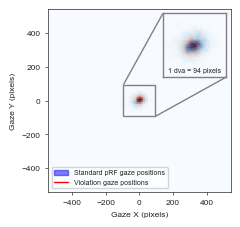

In [17]:
plot_all_gaze_positions()